# Libaray 

In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

# Data Preprocessing

In [ ]:
import warnings  
warnings.filterwarnings("ignore") 

import gc
import numpy as np  
import pandas as pd  
import itertools  
from collections import Counter  
import matplotlib.pyplot as plt  
from sklearn.metrics import ( 
    accuracy_score, 
    roc_auc_score, 
    confusion_matrix,
    classification_report, 
    f1_score 
)

import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,  
    ViTImageProcessor, 
    ViTForImageClassification, 
    DefaultDataCollator
)
import torch 
from torch.utils.data import DataLoader 
from torchvision.transforms import ( 
    CenterCrop,
    Compose,  
    Normalize, 
    RandomRotation, 
    RandomResizedCrop, 
    RandomHorizontalFlip, 
    RandomAdjustSharpness, 
    Resize, 
    ToTensor
)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

8906 8906 52


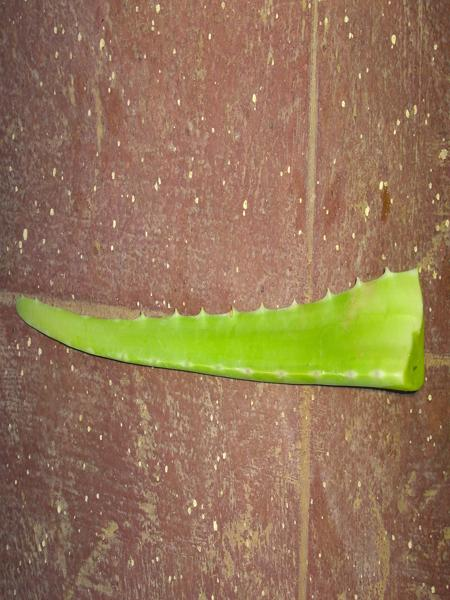

In [ ]:

image_dict = {}
from pathlib import Path
from tqdm import tqdm
import os
MIN_SAMPLES = 100
file_names = []
labels = []

for file in sorted((Path('/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/').glob('*/*/*.jpg'))):
    sample_dir = '/'.join(str(file).split('/')[:-1])+'/'
    num_files_in_dir = [len(x) for _, _, x in os.walk(sample_dir)][0]
    if num_files_in_dir >= MIN_SAMPLES:
        file_names.append(str(file))  
        label = str(file).split('/')[-2] 
        labels.append(label)

print(len(file_names), len(labels), len(set(labels)))

dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())

dataset[0]["image"]

In [ ]:

labels_subset = labels[:5]
print(labels_subset)

['Aloevera', 'Aloevera', 'Aloevera', 'Aloevera', 'Aloevera']


In [ ]:
labels_list = ['Amla', 'Curry', 'Betel', 'Bamboo', 'Palak(Spinach)', 'Coriender', 'Ashoka', 'Seethapala', 'Lemon_grass', 'Pappaya', 'Curry_Leaf', 'Lemon', 'Nooni', 
               'Henna', 'Mango', 'Doddpathre', 'Amruta_Balli', 'Betel_Nut', 'Tulsi', 'Pomegranate', 
                'Castor', 'Jackfruit', 'Insulin', 'Pepper', 'Raktachandini', 'Aloevera', 'Jasmine', 'Doddapatre', 'Neem', 
                'Geranium', 'Rose', 'Gauva', 'Hibiscus', 'Nithyapushpa', 'Wood_sorel', 'Tamarind', 'Guava', 'Bhrami', 'Sapota', 'Basale', 'Avacado', 'Ashwagandha', 'Nagadali', 
                'Arali', 'Ekka', 'Ganike', 'Tulasi', 'Honge', 'Mint', 'Catharanthus', 'Papaya', 'Brahmi']

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i 
    id2label[i] = label 

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Amla', 1: 'Curry', 2: 'Betel', 3: 'Bamboo', 4: 'Palak(Spinach)', 5: 'Coriender', 6: 'Ashoka', 7: 'Seethapala', 8: 'Lemon_grass', 9: 'Pappaya', 10: 'Curry_Leaf', 11: 'Lemon', 12: 'Nooni', 13: 'Henna', 14: 'Mango', 15: 'Doddpathre', 16: 'Amruta_Balli', 17: 'Betel_Nut', 18: 'Tulsi', 19: 'Pomegranate', 20: 'Castor', 21: 'Jackfruit', 22: 'Insulin', 23: 'Pepper', 24: 'Raktachandini', 25: 'Aloevera', 26: 'Jasmine', 27: 'Doddapatre', 28: 'Neem', 29: 'Geranium', 30: 'Rose', 31: 'Gauva', 32: 'Hibiscus', 33: 'Nithyapushpa', 34: 'Wood_sorel', 35: 'Tamarind', 36: 'Guava', 37: 'Bhrami', 38: 'Sapota', 39: 'Basale', 40: 'Avacado', 41: 'Ashwagandha', 42: 'Nagadali', 43: 'Arali', 44: 'Ekka', 45: 'Ganike', 46: 'Tulasi', 47: 'Honge', 48: 'Mint', 49: 'Catharanthus', 50: 'Papaya', 51: 'Brahmi'} 

Mapping of Labels to IDs: {'Amla': 0, 'Curry': 1, 'Betel': 2, 'Bamboo': 3, 'Palak(Spinach)': 4, 'Coriender': 5, 'Ashoka': 6, 'Seethapala': 7, 'Lemon_grass': 8, 'Pappaya': 9, 'Curry_Le

In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']

test_data = dataset['test']

Map:   0%|          | 0/8906 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/8906 [00:00<?, ? examples/s]

In [ ]:
model_str = 'dima806/medicinal_plants_image_detection'

processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),             
        RandomRotation(90),               
        RandomAdjustSharpness(2),         
        RandomHorizontalFlip(0.5),        
        ToTensor(),                       
        normalize      
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),             
        ToTensor(),                     
        normalize                        
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Size:  224


In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [ ]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/2.76k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.838644


In [ ]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }


In [ ]:
metric_name = "accuracy"
model_name = "medicinal_plants_image_detection"

num_train_epochs = 5

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=5e-7,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.19866478443145752,
 'eval_accuracy': 0.997193376368229,
 'eval_runtime': 145.853,
 'eval_samples_per_second': 24.429,
 'eval_steps_per_second': 3.058}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.197251,0.996913
2,No log,0.196479,0.996913
3,0.179600,0.195697,0.996913
4,0.179600,0.195268,0.996913
5,0.179600,0.195176,0.997193


TrainOutput(global_step=835, training_loss=0.1780888768727194, metrics={'train_runtime': 1735.7594, 'train_samples_per_second': 15.391, 'train_steps_per_second': 0.481, 'total_flos': 2.0711262292722893e+18, 'train_loss': 0.1780888768727194, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.1951761394739151,
 'eval_accuracy': 0.997193376368229,
 'eval_runtime': 108.7193,
 'eval_samples_per_second': 32.772,
 'eval_steps_per_second': 4.102,
 'epoch': 5.0}

In [ ]:
outputs = trainer.predict(test_data)

print(outputs.metrics)

{'test_loss': 0.1951761394739151, 'test_accuracy': 0.997193376368229, 'test_runtime': 108.2083, 'test_samples_per_second': 32.927, 'test_steps_per_second': 4.122}


Accuracy: 0.9972
F1 Score: 0.9965


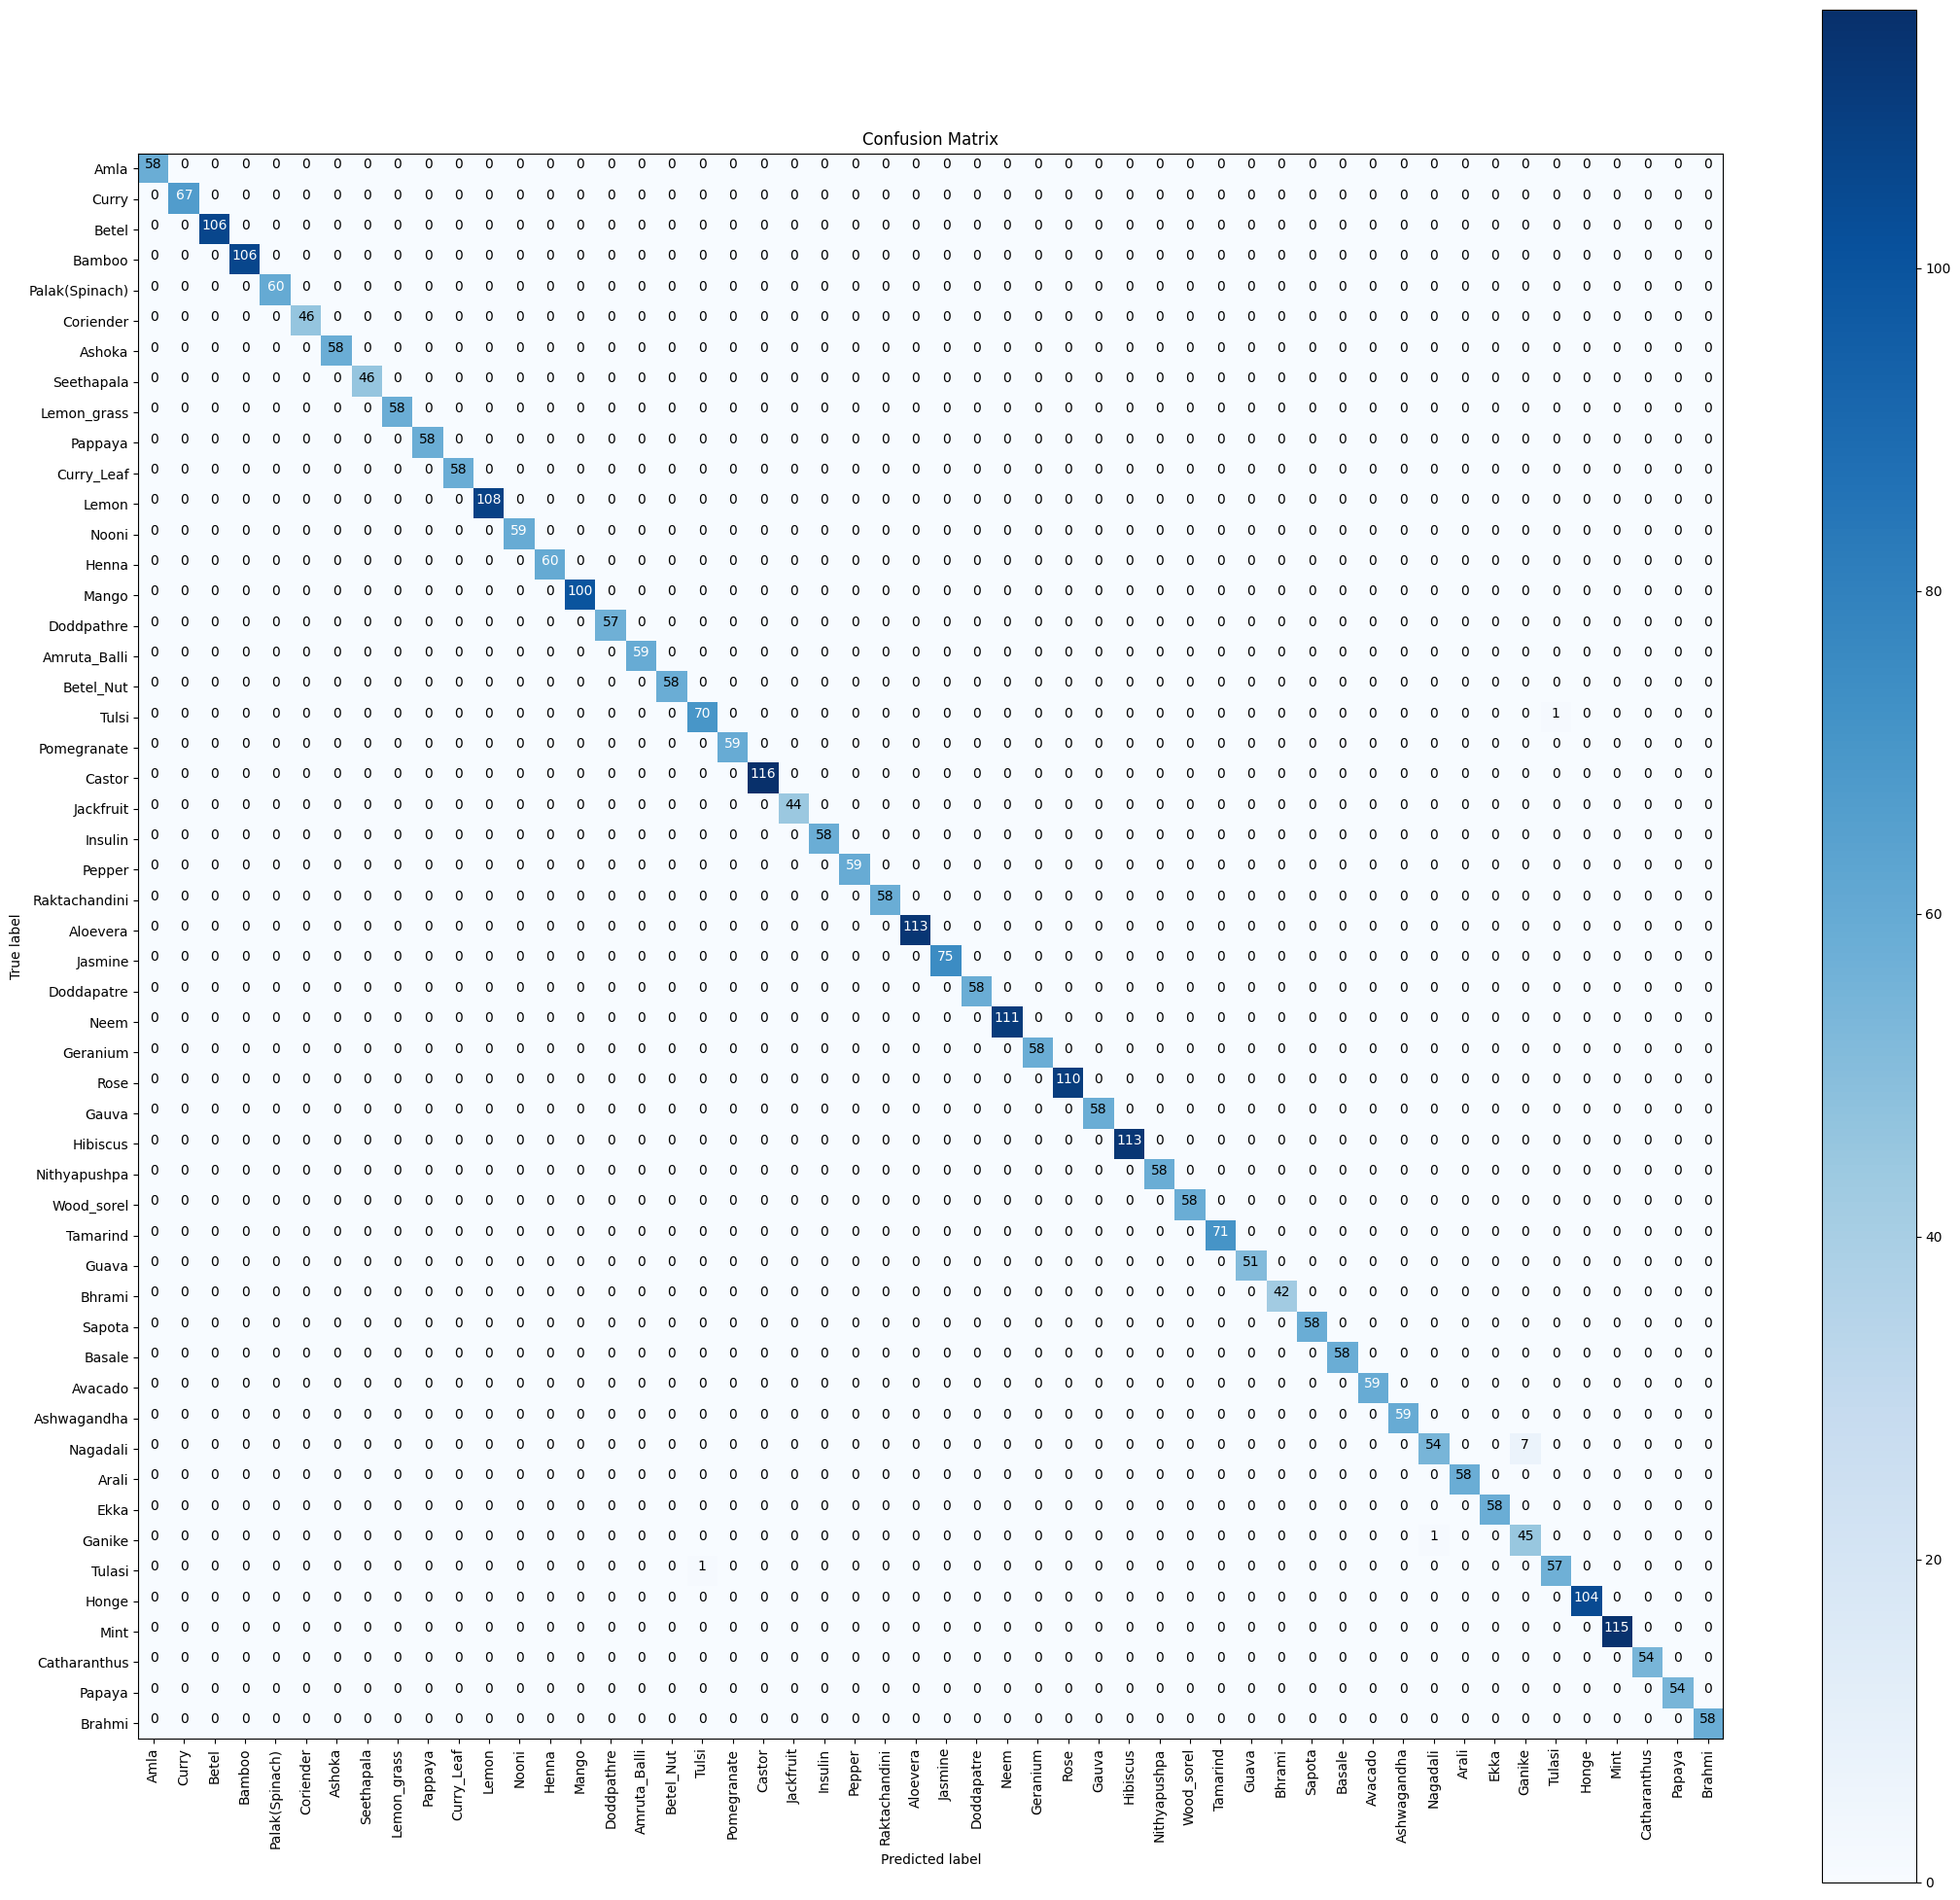


Classification report:

                precision    recall  f1-score   support

          Amla     1.0000    1.0000    1.0000        58
         Curry     1.0000    1.0000    1.0000        67
         Betel     1.0000    1.0000    1.0000       106
        Bamboo     1.0000    1.0000    1.0000       106
Palak(Spinach)     1.0000    1.0000    1.0000        60
     Coriender     1.0000    1.0000    1.0000        46
        Ashoka     1.0000    1.0000    1.0000        58
    Seethapala     1.0000    1.0000    1.0000        46
   Lemon_grass     1.0000    1.0000    1.0000        58
       Pappaya     1.0000    1.0000    1.0000        58
    Curry_Leaf     1.0000    1.0000    1.0000        58
         Lemon     1.0000    1.0000    1.0000       108
         Nooni     1.0000    1.0000    1.0000        59
         Henna     1.0000    1.0000    1.0000        60
         Mango     1.0000    1.0000    1.0000       100
    Doddpathre     1.0000    1.0000    1.0000        57
  Amruta_Balli     1.0

In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(22, 20))
    
print()
print("Classification report:")
print()
try:
    print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))
except:
    pass

In [ ]:
trainer.save_model()

In [ ]:
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)

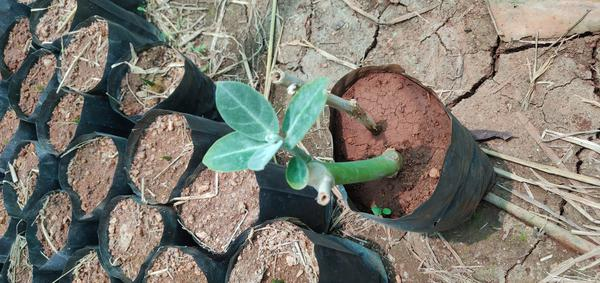

In [ ]:
image = test_data[1]["image"]
image

In [ ]:
pipe(image)

[{'label': 'Ekka', 'score': 0.8336988091468811},
 {'label': 'Tulasi', 'score': 0.005516905803233385},
 {'label': 'Avacado', 'score': 0.0053587546572089195},
 {'label': 'Catharanthus', 'score': 0.005118447355926037},
 {'label': 'Henna', 'score': 0.0048177167773246765}]

In [ ]:
id2label[test_data[1]["label"]]

'Ekka'